In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Read the data
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [3]:
#Get the categorical varaiables
categorical = list(df.dtypes[df.dtypes == object].index)
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [4]:
numerical = list(df.dtypes[df.dtypes != object].index)
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [5]:
# Check for and fill in missing values in categorical and numerical data with 'NA' and 0.0
df[categorical].isnull().sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [6]:
df[categorical] = df[categorical].fillna('NA')
df[categorical].isnull().sum()

lead_source          0
industry             0
employment_status    0
location             0
dtype: int64

In [7]:
df[numerical].isnull().sum()

number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
df[numerical] = df[numerical].fillna(0.0)
df[numerical].isnull().sum()

number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
# Split the data into three parts with train, validation, and test in the ration 60% / 20% / 20%, random_state=1

df_full_train, df_test = train_test_split(df[numerical + categorical], test_size=0.2, random_state=1)
#df_full_train.tail()

In [10]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
#df_val.tail()

In [11]:
len(df) == len(df_train) + len(df_val) + len(df_test)

True

In [12]:
# Retreive the target variabl from the train, validation, and test data sets
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [13]:
# Delete the target variable from the train, validation, and test data sets so as to not mistakenly use them in training
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [14]:
numerical_feat = numerical[0:-1]
numerical_feat

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [15]:
# Converting numerical columns to assumed y_pred
scores = []
for value in numerical_feat:
    df_y_pred = df_train[value]/df_train[value].max()
    y_pred = df_y_pred.values
    auc_score = roc_auc_score(y_train, y_pred)
    scores.append(auc_score)
scores

[0.7635680590007088, 0.5519578313253012, 0.738270176293409, 0.6144993577250176]

In [16]:
# Q1 Highest auc is 'number_of_courses_viewed'

In [17]:
# Training the model
# One-hot encoding
dv = DictVectorizer(sparse=False)

In [18]:
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_train.shape

(876, 31)

In [19]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
X_val.shape

(293, 31)

In [20]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [21]:
#model.intercept_, model.coef_


In [22]:
y_pred = model.predict_proba(X_val)[:,1]
#y_pred

In [23]:
round(roc_auc_score(y_val, y_pred),2)

0.82

In [24]:
# Q2 : Closest answer to 0.81 is 0.72

In [25]:
# Calculating precision and recall for varying threshold values from 0 to 1 with incremental step of 0.01
scores = []
thresholds = np.linspace(0,1,101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    #print(tp, tn, fp, fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    fpr = fp / (fp + tn)
    f1 = (2 * precision * recall) / (precision + recall)

    scores.append((t, tp, tn, fp, fn, precision, recall, fpr, f1))
    

In [26]:
columns = ['threshold', 'tp', 'tn','fp','fn','precision','recall','fpr', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,threshold,tp,tn,fp,fn,precision,recall,fpr,f1
0,0.00,171,0,122,0,0.583618,1.000000,1.0,0.737069
1,0.01,171,0,122,0,0.583618,1.000000,1.0,0.737069
2,0.02,171,0,122,0,0.583618,1.000000,1.0,0.737069
3,0.03,171,0,122,0,0.583618,1.000000,1.0,0.737069
4,0.04,171,0,122,0,0.583618,1.000000,1.0,0.737069
...,...,...,...,...,...,...,...,...,...
96,0.96,3,122,0,168,1.000000,0.017544,0.0,0.034483
97,0.97,1,122,0,170,1.000000,0.005848,0.0,0.011628
98,0.98,0,122,0,171,NaN,0.000000,0.0,NaN
99,0.99,0,122,0,171,NaN,0.000000,0.0,NaN


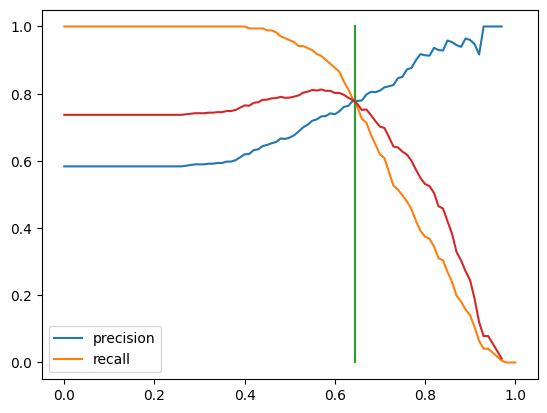

In [27]:
plt.plot(thresholds, df_scores.precision, label='precision')
plt.plot(thresholds, df_scores.recall, label='recall')
plt.legend()
plt.plot([0.645,0.645], [0, 1])
plt.plot(thresholds, df_scores.f1, label='f1')

In [28]:
#df_scores[50:80]

In [29]:
# Q3 : closest is 0.745


In [30]:
#df_scores.f1[50:70]

In [31]:
# Q4 : F1 is maximum at 0.54 threshold

In [32]:
!pip install tqdm

In [33]:
from tqdm.auto import tqdm

In [34]:
# KFold cross-validation

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    # Training the model
    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:,1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.4f, +- %.4f' % (np.mean(scores), np.std(scores)))


    

0it [00:00, ?it/s]

0.8757, +- 0.0318


In [35]:
# Q5 : closest value to the standard deviation from the options is 0.06

In [36]:
# Hyperparameter tuning

#C = [0.000001, 0.001, 1]

n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        # Training the model
        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
    
        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)
    
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
    
        y_pred = model.predict_proba(X_val)[:,1]
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C=%s %.3f, +- %.3f' % (C, round(np.mean(scores),3), round(np.std(scores),3)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.561, +- 0.024
C=0.001 0.926, +- 0.018
C=1 0.876, +- 0.032


In [37]:
# Q6 : Best mean score is 0.926 from C = 0.001